In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

In [2]:
#tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.1f}'.format

semesters = pd.read_csv('terminsstatus_17.txt', sep = '\t')
semesters.head()

,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr
0,E,1,0,20002,20002,15,-7,6.0,15,1
1,W,2,1,20112,20112,37,-7,15.0,37,1
2,D,3,1,20032,20032,21,-7,16.5,21,1
3,N,4,1,20112,20112,37,-7,30.0,37,1
4,W,5,1,20112,20112,37,-7,0.0,37,1


In [3]:
delay_one_term = lambda x: x.shift(+1)
prev_semesters = semesters.apply(delay_one_term)
mean_points = semesters.poang_p.mean()

prev = []
for i,s in enumerate(semesters.lopnr):
    if s == prev_semesters.at[i,'lopnr']:
        prev.append(prev_semesters.at[i, 'poang_p'])
    else:
        prev.append(mean_points)
prev_points_pd = pd.DataFrame(prev)
semesters['prev_points'] = prev_points_pd

# hej'

In [4]:
lopnr_prev = 0
points_first_semester = []
for i, s in enumerate(semesters.lopnr):
    if s != lopnr_prev:
        p = semesters.at[i, 'poang_p']
        points_first_semester.append(p)
    else:
        points_first_semester.append(p)
    lopnr_prev = s
pfs_pd = pd.DataFrame(points_first_semester)
semesters['points_first_semester'] = pfs_pd

In [5]:
lopnr_prev = 0
acc_points = []
for i, p in enumerate(semesters.lopnr):
    if p != lopnr_prev:
        acc_points.append(semesters.at[i,'poang_p'])
    else:
        acc_points.append(acc_points[i-1] + semesters.at[i,'poang_p'])
    lopnr_prev = p
acc_points_pd = pd.DataFrame(acc_points)
#acc_points_pd.head(20)
semesters['accumulated_points'] = acc_points_pd

In [12]:
pd.options.display.max_rows = 40
lopnr_prev = 0
zero_semesters = [0]*semesters.shape[0]
for i, s in enumerate(semesters.lopnr):
    if semesters.at[i,'poang_p'] == 0:
        if s != lopnr_prev:
            zero_semesters[i] += 1
        else:
            zero_semesters[i] = zero_semesters[i-1]+1
        lopnr_prev = s
zs_pd = pd.DataFrame(zero_semesters)
semesters['zero_semesters'] = zs_pd
semesters.head()

,program,lopnr,female,kull,termin,tnr,status,poang_p,kullnr,ptnr,prev_points,points_first_semester,accumulated_points,zero_semesters
0,E,1,0,20002,20002,15,-7,6.0,15,1,16.1,6.0,6.0,0
1,W,2,1,20112,20112,37,-7,15.0,37,1,16.1,15.0,15.0,0
2,D,3,1,20032,20032,21,-7,16.5,21,1,16.1,16.5,16.5,0
3,N,4,1,20112,20112,37,-7,30.0,37,1,16.1,30.0,30.0,0
4,W,5,1,20112,20112,37,-7,0.0,37,1,16.1,0.0,0.0,1


# One-hot encoda string variables

In [7]:
# kod för det här
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

values = semesters.program.copy()
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
onehot_encoded
#print(len(onehot_encoded))
#semesters['one_hot_programs'] = onehot_encoded
#semesters.head()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Välj vilka features vi vill ha

In [117]:
semesters['one_hot'] = pd.Categorical(semesters['program'])

dfDummies = pd.get_dummies(semesters['one_hot'])
semesters2 = pd.concat([semesters, dfDummies],axis=1)

semesters2['one_hot2'] = pd.Categorical(semesters2['kull'])
one_hot_kull = pd.get_dummies(semesters2['one_hot2'])
one_hot_kull
semesters2 = pd.concat([semesters2, one_hot_kull], axis=1)
x = (semesters2[['status', 'prev_points', 'points_first_semester', 'accumulated_points', 'zero_semesters', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'P', 'T', 'V', 'W', 19932, 19942,19952,19962, 19972, 19982, 19992, 20002,20012,20022, 20032, 20042, 20052, 20062, 20072, 20082, 20092, 20102, 20112,20132, 20142, 20152]]).values
#x = (semesters2[['status', 'prev_points', 'points_first_semester', 'accumulated_points', 'zero_semesters', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'P', 'T', 'V', 'W']]).values
y = semesters2.iloc[:, 8].values
x.shape
#semesters2.columns
#print(semesters.groupby(['program', 'ptnr']).poang_p.describe())



(246728, 42)

# Encoda string-variables (när de används)

In [27]:
# kod för det här
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

values = semesters.program.unique().copy()
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
onehot_encoded

/Users/filipvitez/anaconda3/envs/matmod_env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.

# Dela upp i träning och test

In [118]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# Scalea numeriska värden

In [69]:
print(X_train)
from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)
#X_train

[[ 5.  19.5 17.  ...  0.   0.   0. ]
 [ 4.  31.5 30.  ...  0.   0.   0. ]
 [ 7.   0.  25.5 ...  0.   0.   0. ]
 ...
 [ 9.  12.  15.  ...  0.   0.   0. ]
 [-4.   0.   7.5 ...  0.   0.   0. ]
 [ 6.  31.5 18.  ...  0.   0.   0. ]]


# Building the NN

In [119]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(64, input_dim=42, kernel_initializer='normal', 
                activation='relu'))
model.add(Dense(64, kernel_initializer='normal', 
                activation='relu'))

#model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model

model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['mse'])

history = model.fit(X_train,y_train,epochs=20, batch_size=128)


Epoch 1/20
197382/197382 [==============================] - 6s 29us/step - loss: 34.1326 - mean_squared_error: 34.1326
Epoch 2/20
197382/197382 [==============================] - 4s 21us/step - loss: 0.2894 - mean_squared_error: 0.2894
Epoch 3/20
197382/197382 [==============================] - 4s 21us/step - loss: 0.1409 - mean_squared_error: 0.1409
Epoch 4/20
197382/197382 [==============================] - 4s 21us/step - loss: 0.1668 - mean_squared_error: 0.1668
Epoch 5/20
197382/197382 [==============================] - 4s 21us/step - loss: 0.1567 - mean_squared_error: 0.1567
Epoch 6/20
197382/197382 [==============================] - 4s 21us/step - loss: 0.0961 - mean_squared_error: 0.0961
Epoch 7/20
197382/197382 [==============================] - 4s 21us/step - loss: 0.0925 - mean_squared_error: 0.0925
Epoch 8/20
197382/197382 [==============================] - 4s 21us/step - loss: 0.1122 - mean_squared_error: 0.1122 0s - loss:
Epoch 9/20
197382/197382 [=========================

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________


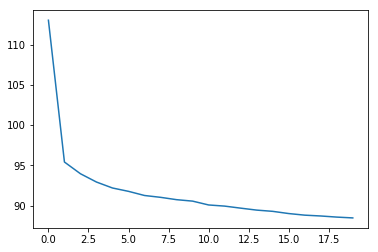

In [75]:
import matplotlib.pyplot as plt

loss = history.history['loss']
num_epochs = np.arange(20)
plt.plot(num_epochs, loss)
plt.show()

In [76]:
history.history

{'loss': [113.01339595017869,
  95.40437242414181,
  93.94770734082171,
  92.91863748180293,
  92.17853250563549,
  91.76262489333767,
  91.24708083182021,
  91.01971629248351,
  90.72860756890212,
  90.54830021339347,
  90.07178203026432,
  89.929748886898,
  89.67623536305634,
  89.43301458579376,
  89.27895033392504,
  89.00498549847923,
  88.80547789208505,
  88.70274799151842,
  88.56474130539291,
  88.4628584621595],
 'mean_squared_error': [113.01339595017869,
  95.40437242414181,
  93.94770734082171,
  92.91863748180293,
  92.17853250563549,
  91.76262489333767,
  91.24708083182021,
  91.01971629248351,
  90.72860756890212,
  90.54830021339347,
  90.07178203026432,
  89.929748886898,
  89.67623536305634,
  89.43301458579376,
  89.27895033392504,
  89.00498549847923,
  88.80547789208505,
  88.70274799151842,
  88.56474130539291,
  88.4628584621595]}